# **MobileNet_with_noice_explainer**

In [1]:
# !pip install -q kaggle

In [2]:
# !unzip -qq  data.zip

In [3]:
#  !mkdir .kaggle

In [4]:
# !cp data/kaggle.json .kaggle/

In [5]:
# !chmod 600 .kaggle/kaggle.json

In [6]:
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset

In [7]:
# !unzip -qq plantvillage-dataset.zip

In [3]:
# %tensorflow_version 2.x
# !pip install shap
# !pip install opencv-python
import os
import itertools
import shutil
import random
import shap
import matplotlib.cm as cm
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd 
from glob import glob
import shutil
import matplotlib.pyplot as plt
# %matplotlib inline

In [4]:
!pwd

/home/thajan/mobilenet


In [5]:

# !mkdir Dataset 
# !mv 'plantvillage dataset'/color/* Dataset
# !pwd
# os.chdir('Dataset')
# if os.path.isdir('train/0/') is False: 
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')
#     filenames = ["Tomato___Bacterial_spot", "Tomato___healthy", "Tomato___Late_blight",
#                 "Tomato___Septoria_leaf_spot","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
#     for i in filenames:
#         shutil.move(f'{i}', 'train')
#         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')

#         valid_samples = random.sample(os.listdir(f'train/{i}'), 159)
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}', f'valid/{i}')

#         test_samples = random.sample(os.listdir(f'train/{i}'), 160)
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('..')

mkdir: cannot create directory ‘Dataset’: File exists
mv: cannot stat 'plantvillage dataset/color/*': No such file or directory
/home/thajan/mobilenet


In [6]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# !pwd

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
train_path = 'Dataset/train'
valid_path = 'Dataset/valid'
test_path = 'Dataset/test'

# train_batches = ImageDataGenerator(
#                                   preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
#                                   rotation_range=10, 
#                                   width_shift_range=0.1, 
#                                   height_shift_range=0.1, 
#                                   shear_range=0.15, 
#                                   zoom_range=0.1, 
#                                   channel_shift_range=10., 
#                                   horizontal_flip=True
#                                   ).flow_from_directory(
#                                                        directory=train_path, 
#                                                        target_size=(224,224),
#                                                        batch_size=16
#                                                       )

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=11160)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=795 )
    
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=800 , shuffle=False)

class_indices = dict((value,key) for key,value in train_batches.class_indices.items())

Found 11160 images belonging to 5 classes.
Found 795 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


In [10]:
def noisy(noise_typ,image,var):
    
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = np.random.random_sample() * var
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

def add_noise(noise_typ,X_imgs,var):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    for X_img in X_imgs:
        gaussian_noise_imgs.append(noisy(noise_typ,X_img,var))
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs
  


In [11]:
var = 0.1
gaussian_noise_train_batches = add_noise("gauss", train_batches[0][0],var)
gaussian_noise_valid_batches = add_noise("gauss", valid_batches[0][0],var)
gaussian_noise_test_batches = add_noise("gauss", test_batches[0][0],var)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


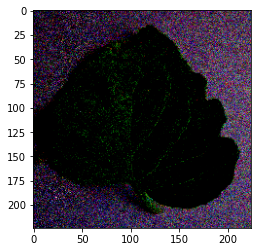

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


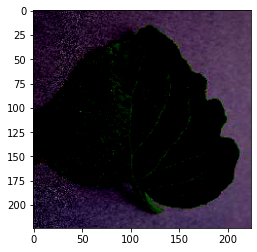

In [12]:
number = 10

plt.imshow(gaussian_noise_train_batches[number])
plt.show()
plt.imshow(train_batches[0][0][number])
plt.show()

In [13]:
mobile = tf.keras.applications.mobilenet.MobileNet()
# mobile.summary()
print(len(mobile.layers))

2022-04-22 22:51:00.252366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thajan/anaconda3/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64:
2022-04-22 22:51:00.280907: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 22:51:00.361028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kaliTH): /proc/driver/nvidia/version does not exist
2022-04-22 22:51:00.907699: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17235968/17225924 [==============================] - 12s 1us/step
91


In [14]:
x = mobile.layers[-6].output

GVP =  tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=5, activation='softmax')(GVP)

model_1 = Model(inputs=mobile.input, outputs=output)

model_2 = Model(inputs=mobile.input, outputs=output)

for layer in model_1.layers[:-23]:
    layer.trainable = False

for layer in model_2.layers[:-23]:
    layer.trainable = False
    
model_1.summary() 
print(len(model_1.layers))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [17]:
#======================================================================
#        Train with the Noised set and noised validation and Test
#======================================================================

model_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_1.fit(x=gaussian_noise_train_batches ,y= train_batches[0][1],
                    batch_size = 1,
                    validation_data=[gaussian_noise_valid_batches,valid_batches[0][1]],
                    epochs=17,
                    verbose=1
)

# model_1 = tf.keras.models.load_model('data/model.h5')

1116/1116 [==============================] - 126s 92ms/step - loss: 0.9715 - accuracy: 0.6478 - val_loss: 0.3852 - val_accuracy: 0.8667


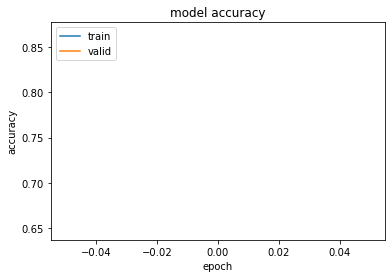

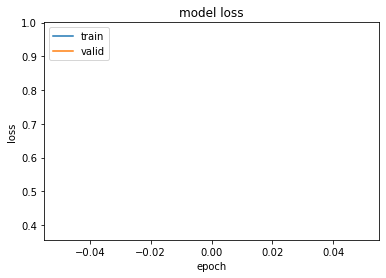

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [19]:
#model = load_model('models/model.h5')

test_labels = test_batches.classes
predictions = model_1.predict(x=gaussian_noise_test_batches, steps=len(gaussian_noise_test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [20]:
y_pred_bool = np.argmax(predictions, axis=1)

print(classification_report(test_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       160
           1       0.89      0.80      0.84       160
           2       0.72      0.96      0.82       160
           3       1.00      0.85      0.92       160
           4       0.92      0.97      0.95       160

    accuracy                           0.87       800
   macro avg       0.88      0.87      0.87       800
weighted avg       0.88      0.87      0.87       800



Confusion matrix, without normalization
[[123   6  28   0   3]
 [  5 128  18   0   9]
 [  4   2 153   0   1]
 [  6   6  12 136   0]
 [  0   2   2   0 156]]


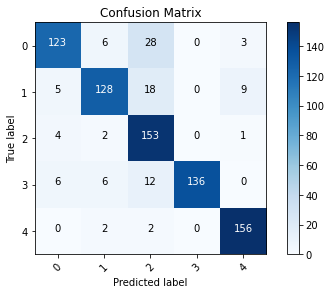

In [21]:
test_batches.class_indices

cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


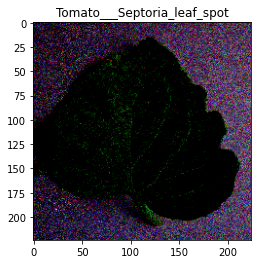

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


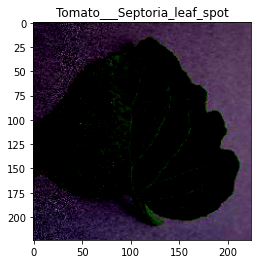

prediction =>  Tomato___Septoria_leaf_spot


In [22]:
number = 10

plt.imshow(gaussian_noise_train_batches[number])
plt.title(class_indices[np.argmax(train_batches[0][1][number])])
plt.show()
plt.imshow(train_batches[0][0][number])
plt.title(class_indices[np.argmax(train_batches[0][1][number])])
plt.show()

img = gaussian_noise_train_batches[number]
input_img = img.reshape((1, *img.shape))
y_pred = model_1.predict(input_img)
print("prediction => ", class_indices[np.argmax(y_pred)])

In [23]:
shap_image_path = "data/shap_test_images/"
shap_image_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=shap_image_path, target_size=(224,224), batch_size=5,shuffle=False )
shap_class_indices = dict((value,key) for key,value in shap_image_batch.class_indices.items())
# test_class_indices = dict((value,key) for key,value in train_batches.class_indices.items())


Found 5 images belonging to 5 classes.


In [24]:
#class names of test batches
test_class_indices = dict((value,key) for key,value in test_batches.class_indices.items())

### **LIME**

Prediction

In [25]:
preds = model_1.predict(input_img)
preds_classes = preds[0].argsort()[::-1]
decode_preds_classes = [class_indices[preds_classes[i]] for i in range(5)]
# print(class_indices)
# print(decode_preds_classes)

Genrate random perturbations or input image

In [30]:
#Generate segmentation for image
import skimage.segmentation
import skimage.io
import copy
import sklearn.metrics
from sklearn.linear_model import LinearRegression
#Create function to apply perturbations to images

def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image


def lime(img, kernal_sz=3, max_dis=100,ratio=0.01):
  double_img = np.array(img,dtype=np.double)
  superpixels = skimage.segmentation.quickshift(double_img, kernel_size= kernal_sz, max_dist=max_dis, ratio=ratio)
  num_superpixels = np.unique(superpixels).shape[0]
  #skimage.io.imshow(skimage.segmentation.mark_boundaries(np.array(double_img,dtype=np.double), superpixels))
  #Generate perturbations
  num_perturb = 300
  perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
  ##Show example of perturbations
  # plt.imshow(perturb_image(double_img,perturbations[0],superpixels))
  # plt.show()
  # plt.imshow(perturb_image(double_img,perturbations[1],superpixels))
  # plt.show()

  # plt.imshow(perturb_image(double_img,perturbations[99],superpixels))
  # plt.show()
  predictions = []
  for pert in perturbations:
    perturbed_img = perturb_image(double_img,pert,superpixels)
    pred = model_1.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

  predictions = np.array(predictions)
  print(predictions.shape)
  #Compute distances to original image

  original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
  distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
  print(distances.shape)

  #Transform distances to a value between 0 an 1 (weights) using a kernel function
  kernel_width = 0.25
  weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
  # print(weights.shape)
  class_to_explain = preds_classes[0] #yellow_curl_virus class
  simpler_model = LinearRegression()
  simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
  coeff = simpler_model.coef_[0]

  #Use coefficients from linear model to extract top features
  num_top_features = 10
  top_features = np.argsort(coeff)[-num_top_features:] 

  #Show only the superpixels corresponding to the top features
  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels
  return perturb_image(double_img,mask,superpixels)
  # (perturb_image(double_img,mask,superpixels))

predict class for each perturbations

In [31]:
lime_image = lime(img)

(300, 1, 5)
(300,)


Compute weights (importance) for the perturbations

## **Saliency map**

In [32]:
layers = [layer.output for layer in model_1.layers]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


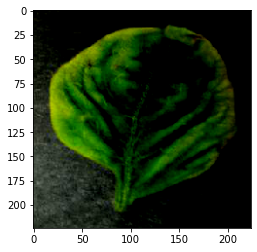

predicted label :  Tomato___Tomato_Yellow_Leaf_Curl_Virus
true label :  Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [33]:
# img = shap_image_batch[0][0][3]
img = shap_image_batch[0][0][3]
plt.imshow(img)
plt.show()
# true_label = test_class_indices[np.argmax(test_batches[0][1][3])]
true_label = shap_class_indices[np.argmax(shap_image_batch[0][1][3])]
input_img = img.reshape((1, *img.shape))
y_pred = model_1.predict(input_img)
pred = y_pred.argmax(axis=-1)
pred_label = shap_class_indices[pred[0]]
# pred_label = test_class_indices[pred[0]]
print( "predicted label : " ,pred_label)
print( "true label : ", true_label)

In [34]:
def vanila_saliencymap(img):
  input_img = img.reshape((1, *img.shape))
  image = tf.Variable(input_img, dtype=float)
  print(img.shape)
  with tf.GradientTape() as tape:
      pred = model_1(image, training=False)
      class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
      loss = pred[0][class_idxs_sorted[0]]
  grads = tape.gradient(loss, image)
  # plt.imshow(grads)
  # plt.show()
  # grads.shape
  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
  # print(dgrad_max_)
  # dgrad_max_.shape
  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
  # grad_eval.shape
  # fig, axes = plt.subplots(1,2,figsize=(14,5))
  # axes[0].imshow(img)
  # i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
  # fig.colorbar(i)
  return grad_eval

In [35]:
saliency_importance_matrix = vanila_saliencymap(img)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


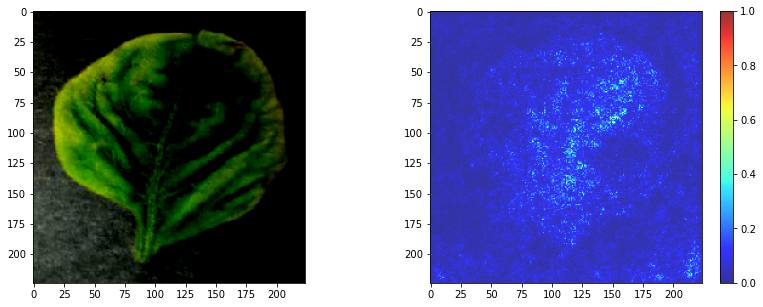

In [36]:
saliency_importance_matrix.shape
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(img)
i = axes[1].imshow(saliency_importance_matrix,cmap="jet",alpha=0.8)
fig.colorbar(i)

## **GradCam and GradCam++**

In [37]:
# for ilayer, layer in enumerate(model_1.layers):
#     print("{:3.0f} {:10}".format(ilayer, layer.name))

In [38]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [39]:
def make_gradcam_heatmap_pp(img_array, model, 
                  last_conv_layer_name,
                  pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = grad_model(img_array)
                if pred_index==None:
                    pred_index = np.argmax(predictions[0])
                output = predictions[:, pred_index]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction label : Tomato___Tomato_Yellow_Leaf_Curl_Virus
true label  : Tomato___Tomato_Yellow_Leaf_Curl_Virus


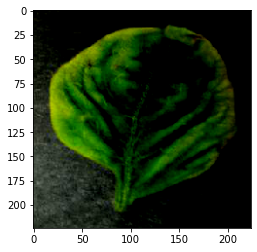

In [40]:
y_pred = np.argmax(model_1.predict(input_img))
print("prediction label :" , class_indices[y_pred])
print("true label  :" , "Tomato___Tomato_Yellow_Leaf_Curl_Virus")
plt.imshow(img)
plt.show()

In [41]:
import matplotlib.cm as cm

def display_gradcam( heatmap, alpha=0.01, beata=1):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)


    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img  * beata
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img) 
    # Display Grad CAM
    return superimposed_img


In [42]:
def gradcam(img):
  input_img = img.reshape((1,  *img.shape))
  heatmap_g = make_gradcam_heatmap(input_img, model_1, 'conv_pw_13_relu', pred_index=None)
  return display_gradcam( heatmap_g)

def gradcam_pp(img):
  input_img = img.reshape((1, *img.shape))
  heatmap_gg = make_gradcam_heatmap_pp(input_img, model_1, 'conv_pw_13_relu', pred_index=None)
  return display_gradcam( heatmap_gg)

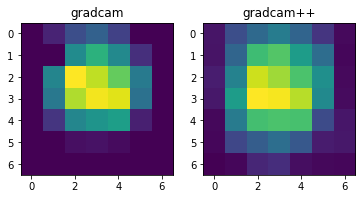

In [43]:
heatmap_g = make_gradcam_heatmap(input_img, model_1, 'conv_pw_13_relu', pred_index=None)
plt.subplot(1,2,1)
plt.imshow(heatmap_g)
plt.title('gradcam')
plt.subplot(1,2,2)
heatmap_gg = make_gradcam_heatmap_pp(input_img, model_1, 'conv_pw_13_relu', pred_index=None)
plt.imshow( heatmap_gg)
plt.title('gradcam++')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


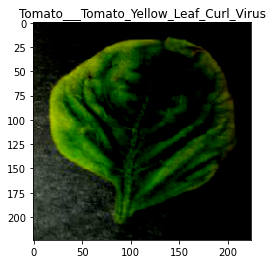

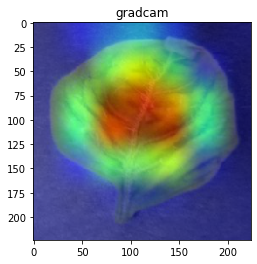

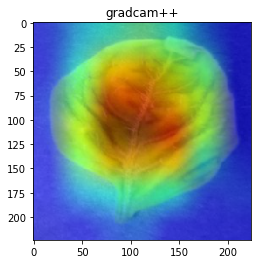

In [44]:
plt.imshow(img)
plt.title(true_label)
plt.show()
print()
grad_matrix = gradcam( img)
plt.imshow(grad_matrix)
plt.title('gradcam')
plt.show()
print()

# plt.subplot(1,2,2)
gradpp_matrix = gradcam_pp( img)
plt.imshow(gradpp_matrix)
plt.title('gradcam++')
plt.show()

## **Shap image explainer**

In [45]:
# image_path = "/content/46f84206-f476-4bed-87da-8db5e6db6e22.jfif"
# img = cv.imread(image_path)
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# img = cv.resize(img , (224,224))
# img = tf.keras.applications.mobilenet.preprocess_input(img)
import shap
def f(x):
    tmp = x.copy()
    return model_1.predict(tmp)


# python function to get model output; replace this function with your own model function.
def shaply(images, class_names):
  
  # define a maker that is used to mask out partitions of the input image.
  masker = shap.maskers.Image("blur(224,224)", img.shape)
  # create an explainer with model and image masker
  explainer = shap.Explainer(f, masker, output_names=class_names)
  # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
  shap_values = explainer(images, batch_size=200,max_evals=5000, outputs=shap.Explanation.argsort.flip[:5])
  return shap_values

In [46]:

list(train_batches.class_indices.keys())


['Tomato___Bacterial_spot',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy']

In [48]:

# images = test_batches[0][0][0:5]
# true_labels = test_batches[0][1][0:5]
shap_images = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory="data/shap_test_images", target_size=(224,224), batch_size=5,shuffle =False)
model_classes = list(train_batches.class_indices.keys())
shap_values = shaply(shap_images[0][0],model_classes)

Found 5 images belonging to 5 classes.


 95%|█████████▍| 2370/2498 [00:52<00:04, 29.85it/s]
2570it [00:55, 35.82it/s]                          
2770it [00:58, 41.65it/s]
 95%|█████████▍| 2370/2498 [00:51<00:02, 54.86it/s]
2570it [00:54, 58.26it/s]                          
2570it [01:06, 58.26it/s]
2770it [01:06, 33.31it/s]
 95%|█████████▍| 2370/2498 [00:38<00:03, 37.21it/s]
2570it [00:42, 42.23it/s]                          
2770it [00:45, 47.42it/s]
 95%|█████████▍| 2370/2498 [00:35<00:02, 55.32it/s]
2570it [00:38, 56.28it/s]                          
2770it [00:41, 56.86it/s]
Partition explainer: 6it [05:17, 63.56s/it]                       


In [49]:
print(shap_values[1].values[:,:,:,2].shape)

(224, 224, 3)


In [50]:
print(img.shape)

(224, 224, 3)


In [51]:
shap.image_plot(shap_values)

matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.


In [52]:
print(shap_values.shape)
for i in range(5):
  print("max" , np.argmax(shap_values[i].base_values),end=" ")
  print("min" , np.argmin(shap_values[i].base_values))
  print(shap_values[i].base_values)

(5, 224, 224, 3, 5)
max 1 min 3
[0.16133688 0.68167877 0.14539741 0.00278823 0.00879877]
max 3 min 0
[0.00462951 0.14865446 0.11515697 0.71841729 0.01314173]
max 2 min 1
[0.27138042 0.00493681 0.6141119  0.08320714 0.02636361]
max 2 min 3
[0.00824777 0.12164905 0.43334502 0.00374997 0.43300828]
max 2 min 3
[0.24856544 0.33321062 0.41130725 0.00153474 0.00538202]


In [53]:
print([val for val in class_indices.values()])

['Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']


In [54]:
# for x in shap_images[0][1]:
#   print([np.argmax(x)])


### Threshold imge

In [56]:
image_green  = cv.imread("data/e5299c52127ddec4624aef1742d4d43b.jpg")
image_green = cv.resize(image_green,(224,224))
image_green= cv.cvtColor(image_green,cv.COLOR_BGR2RGB)

image_balck  = cv.imread("data/wallpaper.png")
image_balck = cv.resize(image_balck,(224,224))
image_black= cv.cvtColor(image_balck,cv.COLOR_BGR2RGB)


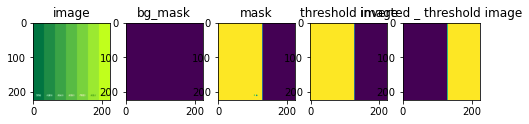

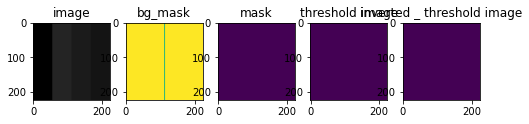

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
def threshold_image( image, only_bg_mask=0, debug=0):
  if debug:
    fig = plt.figure(figsize=(8, 8))  
    fig.add_subplot(1, 5, 1)
    plt.imshow(image)
    plt.title("image")


  blurred = cv.GaussianBlur(image, (5, 5), 0)
  hsv = cv.cvtColor(blurred,  cv.COLOR_RGB2HSV)
  rgb_green = np.uint8([[[0,255,0]]])
  hsv_green = cv.cvtColor(rgb_green, cv.COLOR_RGB2HSV) 

  rgb_black = np.uint8([[[0,0,0]]])
  hsv_black = cv.cvtColor(rgb_black, cv.COLOR_RGB2HSV) 

  bg_lower_limit = np.array([hsv_black[0][0][0], 0 ,0])
  bg_upper_limit = np.array([hsv_black[0][0][0]+300, 20, 30])

  bg_mask0 = cv.inRange(hsv,bg_lower_limit,bg_upper_limit)

  bg_lower_limit = np.array([hsv_black[0][0][0], 0 ,30])
  bg_upper_limit = np.array([hsv_black[0][0][0]+300, 50,250])

  bg_mask = cv.inRange(hsv,bg_lower_limit,bg_upper_limit) + bg_mask0
  blurred_bg_mask = cv.GaussianBlur(bg_mask, (9, 9), 0)
  if debug:
    fig.add_subplot(1, 5, 2)
    plt.imshow(bg_mask)
    plt.title("bg_mask")
  lower_limit = np.array([hsv_green[0][0][0]-10,50,50])
  upper_limit = np.array([hsv_green[0][0][0]+20,255,255])
  mask = cv.inRange(hsv,lower_limit,upper_limit)
  if debug:
    fig.add_subplot(1, 5, 3)
    plt.imshow(mask)
    plt.title("mask")
  if(only_bg_mask):
    exclude_area =  bg_mask
  else:
     exclude_area = mask + bg_mask

  #thresholding
  blur = cv.GaussianBlur(exclude_area,(9,9),0)
  ret3,th_image = cv.threshold(blur,0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)
  threshold_image0 = np.logical_not(th_image).astype(int)
  if debug:
    fig.add_subplot(1, 5, 4)
    plt.imshow(th_image)
    plt.title("threshold image")

  if debug:
    fig.add_subplot(1, 5, 5)
    plt.imshow(threshold_image0)
    plt.title("inverted _ threshold image")
    plt.show()
  return threshold_image0

threshold_image(image_green, debug=1)
threshold_image(image_black, debug=1)

### Normalization

In [58]:
def normalize(array1):
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 255))
  matrix = array1.reshape([-1,1])
  normalized_array = min_max_scaler.fit_transform(matrix)
  normalized_array = normalized_array.reshape(array1.shape)
  return normalized_array

In [59]:
def normalize2(array1):
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 255))
  matrix = array1.reshape([-1,1])
  normalized_array = min_max_scaler.fit_transform(matrix)
  normalized_array = normalized_array.reshape(array1.shape)
  return normalized_array

### Weighted average

In [60]:
def weighted_average(image, th_image):
  return (np.sum(image*th_image)/np.sum(image))*100

## **Model Explainer Performance**

### Testing for one image

Shap

In [62]:
image = cv.imread("data/shap_test_images/Tomato___Bacterial_spot/bacterial_spot.JPG")
image = cv.resize(image,(224,224))
print(image.shape)
image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

th_image = threshold_image(image,1)

(224, 224, 3)


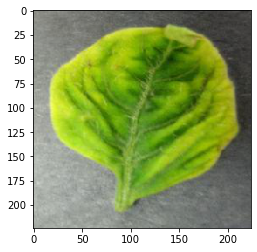

In [63]:
shap_value_of_deault_img_array = shap_values[3].values[:,:,:,0]
plt.imshow(tf.keras.preprocessing.image.array_to_img(shap_values[3].data))
plt.show()

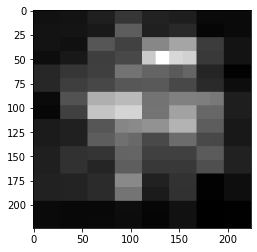

(224, 224, 3)
False
False


In [64]:
plt.imshow(keras.preprocessing.image.array_to_img(shap_value_of_deault_img_array))
plt.show()
print(shap_value_of_deault_img_array.shape)
#checking 3 channels has same values
print(False in (shap_value_of_deault_img_array[:,:,0]==shap_value_of_deault_img_array[:,:,1]))
print(False in (shap_value_of_deault_img_array[:,:,0]==shap_value_of_deault_img_array[:,:,2]))

In [65]:
#normalizing and scaling to (0,255) shap value

shap_values_matrix =  shap_value_of_deault_img_array[:,:,0]
shap_values_matrix[shap_values_matrix<=0] = 0
normalized_shap_values = normalize(shap_values_matrix)

Saliency

In [66]:
normalized_saliency_importance_matrix = normalize(saliency_importance_matrix) 

GradCam and GradCam++

In [67]:
grad_importancy_matrix = keras.preprocessing.image.img_to_array(grad_matrix) 
gradpp_importancy_matrix = keras.preprocessing.image.img_to_array(gradpp_matrix) 


Perfomance

In [68]:
print("saliency map weighted_average  : {0:8.2f}%".format(weighted_average(saliency_importance_matrix, th_image)))
print("gradcam weighted_average       : {0:8.2f}%".format(weighted_average(grad_importancy_matrix[:,:,0], th_image)))
print("gradcam++ weighted_average     : {0:8.2f}%".format(weighted_average(gradpp_importancy_matrix[:,:,0], th_image)))
print("shap weighted_average          : {0:8.2f}%".format(weighted_average(normalized_shap_values, th_image)))


saliency map weighted_average  :    55.81%
gradcam weighted_average       :    58.96%
gradcam++ weighted_average     :    62.28%
shap weighted_average          :    82.76%


## **Performance of test image test**

### Load image data set

In [69]:
import matplotlib.image as mpimg

test_images_dataset = {}
folder = 'Dataset/test/'
for class_name in os.listdir(folder):
    try:
      if class_name not in test_images_dataset:
        test_images_dataset[class_name]=[]
      class_path = os.path.join(folder,class_name)
      
      for file_name in os.listdir(class_path):
        try : 
          img = cv.imread(os.path.join(class_path,file_name))
          img = cv.resize(img,(224,224))
          img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
          if img is not None:
            test_images_dataset[class_name].append(img)
        except:
          print('Cant import ' + file_name)
          
    except:
        print('Cant import ' + class_name)

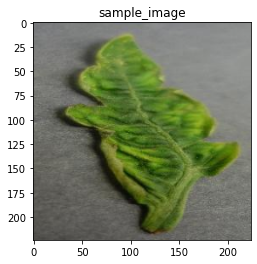

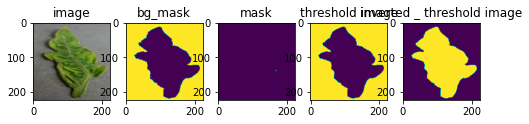

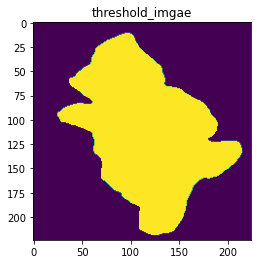

In [70]:
plt.imshow(test_images_dataset[list(test_images_dataset.keys())[0]][20])
plt.title("sample_image")
plt.show()

plt.imshow(threshold_image(test_images_dataset[list(test_images_dataset.keys())[0]][20],debug=1))
plt.title("threshold_imgae")
plt.show()


In [71]:
train_batches.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Late_blight': 1,
 'Tomato___Septoria_leaf_spot': 2,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 3,
 'Tomato___healthy': 4}

Tomato___Tomato_Yellow_Leaf_Curl_Virus


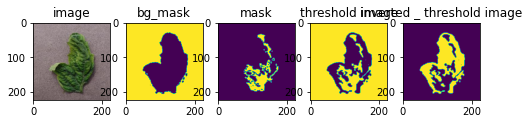

Partition explainer: 2it [01:06, 66.19s/it]               


(224, 224, 3)
Tomato___Tomato_Yellow_Leaf_Curl_Virus


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7febf8c57910>
Traceback (most recent call last):
  File "/home/thajan/anaconda3/envs/tensorflow/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


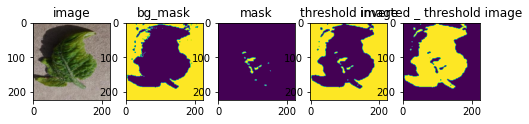

Partition explainer: 2it [00:46, 46.00s/it]               


(224, 224, 3)
Tomato___Tomato_Yellow_Leaf_Curl_Virus


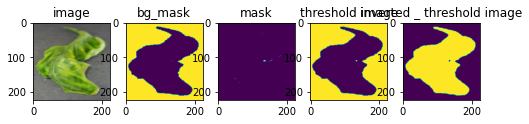

Partition explainer: 2it [00:50, 50.58s/it]               


(224, 224, 3)
Tomato___Tomato_Yellow_Leaf_Curl_Virus


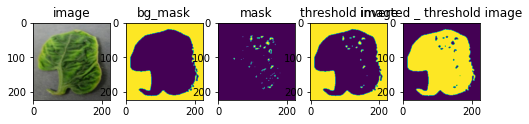

Partition explainer: 2it [01:03, 63.77s/it]               


(224, 224, 3)
Tomato___Tomato_Yellow_Leaf_Curl_Virus


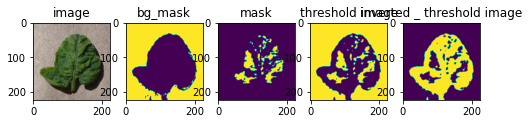

Partition explainer: 2it [01:08, 68.27s/it]               


(224, 224, 3)
Tomato___Tomato_Yellow_Leaf_Curl_Virus


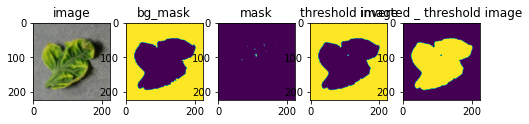

In [ ]:
from sklearn.utils import shuffle
# images = test_batches[0][0]
# labels_class = test_batches.class_indices
# labels = test_batches[0][1]

train_labels = list(train_batches.class_indices.keys())

weighted_average_values_of_images = {
    "image" : [],
    "shap":[],
    "grad":[],
    "grad_pp":[],
    "saliency":[],
    "confidence":[],
    "true_class":[],
    "predicted_class":[]
}



for label in test_images_dataset.keys():
  i = 0
  only_bg = "Tomato___healthy"==label
  for image in test_images_dataset[label]:
    print(label)
    
    th_image = threshold_image(image,only_bg,1)
    
    weighted_average_values_of_images['image'].append( tf.keras.preprocessing.image.array_to_img(image))
    weighted_average_values_of_images['true_class'].append(label)
    

    preprocessed_img = tf.keras.applications.mobilenet.preprocess_input(image)
    preprocessed_img = preprocessed_img.reshape(1, *preprocessed_img.shape)

    shap_values_matrix = shaply(preprocessed_img,train_labels)[0].values[:,:,:,0][:,:,0]
    shap_values_matrix[shap_values_matrix<=0] = 0
    normalized_shap_values = normalize(shap_values_matrix)
    weighted_average_values_of_images["shap"].append(weighted_average(normalized_shap_values,th_image))

    # for col in normalized_shap_values:
    #   for row in col:
    #     if(row>200):
    #       print(row)

    #gradcam
    grad_importancy_matrix = keras.preprocessing.image.img_to_array(gradcam(image)) 
    normalized_grad_importancy_matrix = normalize(grad_importancy_matrix)
    weighted_average_values_of_images["grad"].append(weighted_average(normalized_grad_importancy_matrix[:,:,0],th_image))
    # print(normalized_grad_importancy_matrix)

    # #gradcam_pp
    gradpp_importancy_matrix = keras.preprocessing.image.img_to_array(gradcam_pp(image)) 
    normalized_gradpp_importancy_matrix = normalize(gradpp_importancy_matrix)
    weighted_average_values_of_images["grad_pp"].append(weighted_average(normalized_gradpp_importancy_matrix[:,:,0],th_image))

    
    # print(normalized_gradpp_importancy_matrix, end=" ")

    # #vanila slaiency
    normalized_saliency_importance = normalize(vanila_saliencymap(image))
    weighted_average_values_of_images["saliency"].append(weighted_average(normalized_saliency_importance,th_image))

    prediction = model_1.predict(preprocessed_img)[0]
    weighted_average_values_of_images["confidence"].append(np.max(prediction)*100)

    weighted_average_values_of_images['predicted_class'].append(train_labels[np.argmax(prediction)])
    # print(saliency_importance)
    # for col in saliency_importance:
    #   for row in col:
    #     if(row<10):
    #       print(row)
  
    




In [ ]:

df = pd.DataFrame.from_dict(weighted_average_values_of_images)
df.to_csv('file1.csv')

In [ ]:
# !jupyter nbconvert --to html "MobileNet_with_noice_explainer(2).ipynb"